# Encoding Wind and Solar Installed Capacities

As expected, the amont of solar and wind generated electricity is increasing yearly since 2015, as the installed capacities have been increasing as well.

In the first part of the notebook, we will show the increase in solar and wind generation

In the second part we will create a dataframe with the generation capacity at each given day. For this we use the aggregated data from ["Open Power System Data"](https://open-power-system-data.org/)

In [260]:
import pandas as pd
import numpy as np
import datetime
import plotly.express as px
import geopandas as gpd
import matplotlib.pyplot as plt
import time

In [2]:
entsoe_data_path = '/Users/juangarcia/Documents/Data_Science/03_DSR/Final_Project/erste_repo/Residual_Load/Data_collection_entsoe/Day_ahead_dataset.csv'
df = pd.read_csv(entsoe_data_path)

In [3]:
# do small changes to the dataframe to further work with it
df.drop(columns='index', inplace=True)
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d %H:%M:%S')

## Solar Generation

In [115]:
# function to generate a graph at different aggregation levels of a given variable
# e.g. solar generation

def get_generation_trend(df, var):
    # create a dataframe with only the variable of interest and the time stamp
    df_var = df.loc[:, ['Date', var]]
    df_var.Date = pd.to_datetime(df_var.Date, format='%Y-%m-%d %H:%M:%S')
    
    # Aggregate on different levels
    # year
    df_var_year = df_var.copy()
    df_var_year.insert(loc=1, column='year', value=df_var.Date.dt.year)
    df_var_year = pd.DataFrame(data=df_var_year.groupby(['year'])[var].mean())
    df_var_year.reset_index(inplace=True)
    # plot
    fig = px.line(
        data_frame=df_var_year,
        x='year',
        y=var,
        title=f'Yearly generation of {var}',
        )
    fig.show()    
    
    # month
    df_var_month = df_var.copy()
    df_var_month.insert(loc=1, column='year', value=df_var.Date.dt.year)
    df_var_month.insert(loc=2, column='month', 
                       value=df_var_month.Date.dt.month)
    df_var_month = pd.DataFrame(data=df_var_month.groupby(['year', 'month'])[var].mean())
    df_var_month.reset_index(inplace=True)
    df_var_month['year_month'] = df_var_month.apply(lambda x: str(x['year']) + '-' + \
                                                 str(x['month']), axis=1)
    # plot
    fig = px.line(
        data_frame=df_var_month,
        x='year_month',
        y=var,
        title=f'Monthly generation of {var}',
        )
    fig.show() 

    # Week
    df_var_week = df_var.copy()
    df_var_week.insert(loc=1, column='year', value=df_var.Date.dt.year)
    df_var_week.insert(loc=2, column='week', 
                       value=df_var_week.Date.dt.isocalendar().week)
    df_var_week = pd.DataFrame(data=df_var_week.groupby(['year', 'week'])[var].mean())
    df_var_week.reset_index(inplace=True)
    df_var_week['year_week'] = df_var_week.apply(lambda x: str(x['year']) + '-' + \
                                                 str(x['week']), axis=1)
    # plot
    fig = px.line(
        data_frame=df_var_week,
        x='year_week',
        y=var,
        title=f'Weekly generation of {var}',
        )
    fig.show()
    
    del df_var_week

    # Day
    df_var_day = df_var.copy()
    df_var_day.insert(loc=1, column='day', value=df_var.Date.dt.date)
    df_var_day = pd.DataFrame(data=df_var_day.groupby(['day'])[var].mean())
    df_var_day.reset_index(inplace=True)
    # plot
    fig = px.line(
        data_frame=df_var_day,
        x='day',
        y=var,
        title=f'Daily generation of {var}',
        )
    fig.show()
    
    del df_var_day

In [116]:
df.columns

Index(['Date', 'Day ahead/System total load in MAW', 'Realised/Solar in MAW',
       'Day ahead/Solar in MAW', 'Day ahead/Wind Onshore in MAW',
       'Day ahead/Wind Offshore in MAW', 'Realised/Wind Onshore in MAW',
       'Realised/System total load in MAW', 'Realised/Wind Offshore in MAW'],
      dtype='object')

In [118]:
# get an overview of each relevant feature

features = ['Realised/Solar in MAW', 'Realised/Wind Onshore in MAW', 'Realised/Wind Offshore in MAW']

for feature in features:
    get_generation_trend(df, feature)

## Get data about installed capacities in germany

Some of the data was already collected by "Open Power System Data" - All information regarding this dataset and a download link can be founded [here](https://data.open-power-system-data.org/renewable_power_plants/)

Data for the year 2020 was retreived from the "Bundesnetzagentur" - to download the data please follow this [link](https://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/ErneuerbareEnergien/ZahlenDatenInformationen/EEG_Registerdaten/EEG_Registerdaten_node.html)

For the geographical information we used the databank from the "Marktstammdatenregister" - to download the data please follow this [link](https://www.marktstammdatenregister.de/MaStR/Einheit/Einheiten/ErweiterteOeffentlicheEinheitenuebersicht)

In [164]:
# load csv file
df_capacity = pd.read_csv('renewable_power_plants_DE.csv')

/Users/juangarcia/opt/anaconda3/envs/residual_load_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning:

Columns (14,19) have mixed types.Specify dtype option on import or set low_memory=False.



In [165]:
df_capacity.describe()

,electrical_capacity,lon,lat,municipality_code,postcode,decommissioning_date,dso_id
count,1.940184e+06,1.938685e+06,1.938685e+06,1.860822e+06,1.940020e+06,0.0,1.860259e+06
mean,5.700920e-02,9.796786e+00,5.019917e+01,7.943124e+06,6.224719e+04,NaN,1.000213e+07
std,3.918289e-01,1.962753e+00,1.765567e+00,3.010015e+06,2.693467e+04,NaN,1.893524e+03
min,1.000000e-06,5.988064e+00,4.736293e+01,7.081800e+04,0.000000e+00,NaN,1.000005e+07
25%,5.520000e-03,8.281806e+00,4.868960e+01,5.911000e+06,3.835000e+04,NaN,1.000104e+07
50%,9.000000e-03,9.615023e+00,4.983181e+01,8.315030e+06,6.782400e+04,NaN,1.000150e+07
75%,1.729000e-02,1.127483e+01,5.158013e+01,9.376159e+06,8.655400e+04,NaN,1.000300e+07
max,1.389000e+02,1.498289e+01,5.502013e+01,1.607705e+07,9.999800e+04,NaN,1.001218e+07


In [167]:
# get only the relevant columns and renewables
df_ren = df_capacity[['electrical_capacity', 
             'energy_source_level_1',
             'energy_source_level_2',
             'technology', 
             'commissioning_date',
             'decommissioning_date',
             'lon',
             'lat']]


df_ren = df_ren.query('energy_source_level_2 in ["Solar", "Wind"]')

# set the date columns to datetime format
df_ren.loc[:, 'commissioning_date'] = pd.to_datetime(df_ren.loc[:, 'commissioning_date'], format='%Y-%m-%d')
df_ren.loc[:, 'decommissioning_date'] = pd.to_datetime(df_ren.loc[:, 'decommissioning_date'], format='%Y-%m-%d')


In [202]:
# create a new dataframe to store installed capacity (IC) by date
df_ren_IC = pd.DataFrame({'date': df.Date.dt.date})
df_ren_IC.drop_duplicates(inplace=True)

# start all columns with zeros
df_ren_IC['Photovoltaics'] = 0
df_ren_IC['Photovoltaics ground'] = 0
df_ren_IC['Onshore'] = 0
df_ren_IC['Offshore'] = 0

df_ren_IC.head(2)

In [ ]:
'df_ren_solar_wind' = 'df_ren'

In [225]:
# Save the values for accumulated installed capacities in the df_ren_IC
technologies = ['Photovoltaics', 'Photovoltaics ground', 'Onshore', 'Offshore']

for typ in technologies:
    for day in df_ren_IC.date.values:
        value = df_ren.query('commissioning_date <= @day & technology == @typ').electrical_capacity.sum()
        mask = df_ren_IC.date == day
        df_ren_IC.loc[mask, typ] = value  
        
df_ren_IC.head()

## Getting the values for 2020

In [265]:
# after downloading the excel file create the respective dataframes for solar and wind
df_excel_wind = pd.read_excel('2020_09_EEGZubauwerte.xlsx', 
                             sheet_name='Wind', header=25)

df_excel_solar = pd.read_excel('2020_09_EEGZubauwerte.xlsx', 
                             sheet_name='Solar', header=27)

28.667346000671387


In [270]:
# get only the data for 2020
mask_wind = df_excel_wind['Inbetriebnahmedatum der EEG-Anlage'] >= '2020-01-01'
mask_solar = df_excel_solar['Inbetriebnahme-\ndatum der EEG-Anlage'] >= '2020-01-01'

df_excel_wind = df_excel_wind.loc[mask_wind]
df_excel_solar = df_excel_solar.loc[mask_solar]

In [337]:
# create sub dataframes for wind onshore, offshore
df_excel_wind_onshore = df_excel_wind.loc[df_excel_wind['Lage (Wind)'] == 'Windkraft an Land']
df_excel_wind_offshore = df_excel_wind.loc[df_excel_wind['Lage (Wind)'] == 'Windkraft auf See']


In [338]:
# add the data to the df_ren_IC
# for wind onshore
for day in df_ren_IC.query('date >= "2020-01-01"').date.values:
    mask = df_excel_wind_onshore.loc[:, 'Inbetriebnahmedatum der EEG-Anlage'] <= day
    value = df_excel_wind_onshore.loc[mask, 'Installierte Leistung der EEG-Anlage [kW]'].sum()/1000 
    mask = df_ren_IC.date == day
    df_ren_IC.loc[mask, 'Onshore'] += value  

# for wind offshore
for day in df_ren_IC.query('date >= "2020-01-01"').date.values:
    mask = df_excel_wind_offshore.loc[:, 'Inbetriebnahmedatum der EEG-Anlage'] <= day
    value = df_excel_wind_offshore.loc[mask, 'Installierte Leistung der EEG-Anlage [kW]'].sum()/1000 
    mask = df_ren_IC.date == day
    df_ren_IC.loc[mask, 'Offshore'] += value  
    
# for solar
for day in df_ren_IC.query('date >= "2020-01-01"').date.values:
    mask = df_excel_solar.loc[:, 'Inbetriebnahme-\ndatum der EEG-Anlage'] <= day
    value = df_excel_solar.loc[mask, 'Installierte Leistung der EEG-Anlage [kW]'].sum()/1000 
    mask = df_ren_IC.date == day
    df_ren_IC.loc[mask, 'Photovoltaics'] += value 
    

In [356]:
df_ren_IC

,date,Photovoltaics,Photovoltaics ground,Onshore,Offshore
0,2014-12-31,37247.066770,0.000000,27243.961160,666.820
4,2015-01-01,37248.020735,0.000000,27246.461160,666.820
100,2015-01-02,37249.801240,0.000000,27258.886160,666.820
196,2015-01-03,37249.992885,0.000000,27258.886160,666.820
292,2015-01-04,37250.016525,0.000000,27258.886160,666.820
...,...,...,...,...,...
203620,2020-10-22,53121.771426,791.828546,45575.827937,5960.514
203716,2020-10-23,53121.771426,791.828546,45575.827937,5960.514
203812,2020-10-24,53121.771426,791.828546,45575.827937,5960.514
203908,2020-10-25,53121.771426,791.828546,45575.827937,5960.514


In [ ]:
# store dataframe as csv
df_ren_IC.to_csv('Installed_capacities_time.csv', index=False)

In [ ]:
raise Exception('The map bellow will not be generated')

(1940184, 9)


<AxesSubplot:>

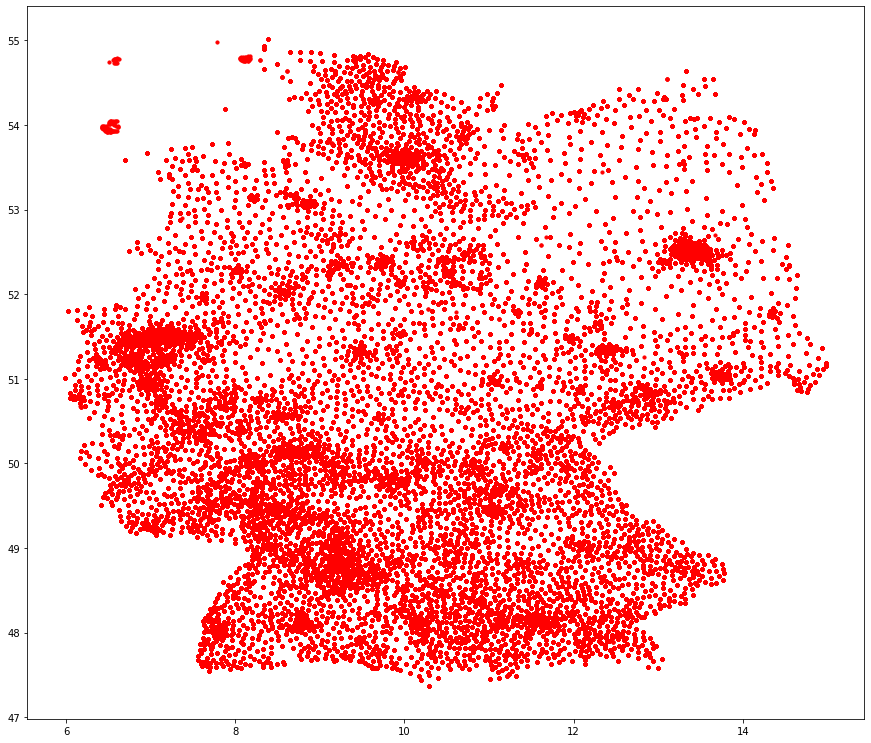

In [360]:
#crs = {'init': 'epsg:4326'}
#geo_df = gpd.GeoDataFrame(df_ren_2, 
#                          geometry = gpd.points_from_xy(df_ren_2.lon, 
#                                                        df_ren_2.lat))

# Get rid of wrong labeled stations
print(geo_df.shape)
#geo_df_3 = geo_df.drop(geo_df.query('latitude < 40').index)

# create the plot
fig, ax = plt.subplots(figsize=(15,15))
geo_df.plot(ax=ax, markersize=10, color='red', marker = 'o')
#geo_df_2.plot(ax=ax, markersize=30, color='blue', marker = 'o')